# Regresión logística: Sigmoid vs Tanh

Comparación de dos funciones de activación en un mismo problema de clasificación binaria (dataset **Pima Indians Diabetes**). Cada bloque (Sigmoid y Tanh) es **independiente**: no hace falta comentar ni descomentar código.

**Estructura del cuaderno:**
- **1. Preparación de los datos** — Importaciones, carga del dataset y normalización.
- **2. Modelo con Sigmoid** — Flujo completo: activación, propagación, optimización, predicción, entrenamiento, gráficas y análisis.
- **3. Modelo con Tanh** — Mismo flujo con activación tanh y coste MSE.
- **4. Comparación** — Gráficas y análisis comparativo entre ambos.

---

## 1. Preparación de los datos

Se cargan las librerías, el dataset **Pima Indians Diabetes** (OpenML) y se normalizan los datos para un entrenamiento estable.

**Importaciones**

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

%matplotlib inline

**Carga del dataset** — Pima Indians Diabetes (clasificación binaria: diabetes sí/no). Se descarga desde OpenML, se convierten etiquetas a 0/1 y se eliminan filas con NaN. Salida en formato *(n_features, n_muestras)*.

In [3]:
def load_dataset_sklearn():
    """
    Carga el dataset Pima Indians Diabetes desde OpenML.
    - Convierte etiquetas a 0/1 (tested_positive -> 1).
    - Elimina filas con NaN.
    - Devuelve X en forma (n_features, n_muestras) para compatibilidad con el modelo.
    Returns:
        X_train, y_train, X_test, y_test, classes
    """
    data = fetch_openml('diabetes', version=1, as_frame=False, parser='auto')
    X = data.data
    y = data.target

    if y.dtype == object or np.issubdtype(y.dtype, np.character):
        y = (y == 'tested_positive').astype(np.float64)
    else:
        y = y.astype(np.float64)

    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X, y = X[mask], y[mask]
    y = y.reshape(1, -1)
    X = X.T  # (n_features, n_samples)

    X_train, X_test, y_train, y_test = train_test_split(
        X.T, y.T, test_size=0.2, random_state=42
    )
    X_train, X_test = X_train.T, X_test.T
    y_train, y_test = y_train.T, y_test.T

    classes = np.array(['no_diabetes', 'diabetes'])
    return X_train, y_train, X_test, y_test, classes

**Cargar datos y normalizar** — Normalización por media 0 y desviación típica ~1 (estabilidad del entrenamiento).

In [30]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset_sklearn()

train_set_x = (train_set_x_orig - train_set_x_orig.mean(axis=1, keepdims=True)) / (train_set_x_orig.std(axis=1, keepdims=True) + 1e-8)
test_set_x = (test_set_x_orig - train_set_x_orig.mean(axis=1, keepdims=True)) / (train_set_x_orig.std(axis=1, keepdims=True) + 1e-8)

**Dimensiones** — Tamaño de entrenamiento, test y número de características.

In [31]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
n_features = train_set_x.shape[0]
print("Ejemplos entrenamiento:", m_train)
print("Ejemplos test:", m_test)
print("Características:", n_features)
print("train_set_x:", train_set_x.shape, " | train_set_y:", train_set_y.shape)
print("test_set_x:", test_set_x.shape, " | test_set_y:", test_set_y.shape)

Ejemplos entrenamiento: 614
Ejemplos test: 154
Características: 8
train_set_x: (8, 614)  | train_set_y: (1, 614)
test_set_x: (8, 154)  | test_set_y: (1, 154)


**Inicialización de parámetros** — Función compartida para inicializar \(w\) (ceros) y \(b\) (0).

In [32]:
def initialize_with_zeros(dim):
    """
    Inicializa los parámetros del modelo (regresión logística).
    - w: vector de ceros de forma (dim, 1).
    - b: escalar 0.
    """
    w = np.zeros(shape=(dim, 1))
    b = 0
    return w, b

---

## 2. Modelo con Sigmoid

En esta sección se entrena una regresión logística usando **activación sigmoid** y **coste cross-entropy**. Todo el flujo es independiente: no se comparte código con la sección Tanh.

**Activación sigmoid** — Salida en \((0, 1)\). Se usa con cross-entropy.

In [33]:
def sigmoid(z):
    """
    Función de activación sigmoid. Salida en (0, 1).
    Se usa junto con la función de coste cross-entropy.
    """
    return 1 / (1 + np.exp(-z))

**Propagación (forward y backward)** — Coste cross-entropy y gradientes para sigmoid.

In [34]:
def propagate_sigmoid(w, b, X, Y):
    """
    Forward y backward con sigmoid + cross-entropy.
    Calcula el coste J y los gradientes dw, db.
    """
    m = X.shape[1]

    # Forward: A = sigmoid(w^T X + b)
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    # Backward: gradientes
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    cost = np.squeeze(cost)
    return {"dw": dw, "db": db}, cost

**Optimización** — Descenso de gradiente usando la propagación sigmoid.

In [35]:
def optimize_sigmoid(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    Descenso de gradiente: en cada iteración calcula coste y gradientes
    con propagate_sigmoid y actualiza w, b.
    Devuelve parámetros finales, últimos gradientes y lista de costes (cada 100 iter).
    """
    costs = []

    for i in range(num_iterations):
        grads, cost = propagate_sigmoid(w, b, X, Y)
        dw, db = grads["dw"], grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    return {"w": w, "b": b}, grads, costs

**Predicción** — Umbral 0.5 sobre la salida sigmoid.

In [36]:
def predict_sigmoid(w, b, X):
    """
    Predicción con sigmoid: clase 1 si A > 0.5, si no 0.
    Devuelve Y_prediction de forma (1, m).
    """
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    Y_prediction = (A > 0.5).astype(np.float64)
    return Y_prediction

**Modelo completo (sigmoid)** — Inicializa, optimiza y predice. Devuelve costes y predicciones.

In [37]:
def model_sigmoid(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Entrena el modelo completo con sigmoid: inicializa, optimiza y predice.
    Devuelve un diccionario con costs, predicciones, w, b, acc_train, acc_test, etc.
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize_sigmoid(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w, b = params["w"], params["b"]

    Y_prediction_test = predict_sigmoid(w, b, X_test)
    Y_prediction_train = predict_sigmoid(w, b, X_train)

    acc_train = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    acc_test = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100

    print("train accuracy: %.2f %%" % acc_train)
    print("test accuracy: %.2f %%" % acc_test)

    return {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w, "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations,
        "acc_train": acc_train,
        "acc_test": acc_test
    }

**Entrenar modelo sigmoid**

In [38]:
d_sigmoid = model_sigmoid(train_set_x, train_set_y, test_set_x, test_set_y,
                          num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.639638
Cost after iteration 200: 0.603081
Cost after iteration 300: 0.577159
Cost after iteration 400: 0.558090
Cost after iteration 500: 0.543601
Cost after iteration 600: 0.532289
Cost after iteration 700: 0.523258
Cost after iteration 800: 0.515913
Cost after iteration 900: 0.509846
Cost after iteration 1000: 0.504771
Cost after iteration 1100: 0.500479
Cost after iteration 1200: 0.496816
Cost after iteration 1300: 0.493665
Cost after iteration 1400: 0.490936
Cost after iteration 1500: 0.488560
Cost after iteration 1600: 0.486479
Cost after iteration 1700: 0.484649
Cost after iteration 1800: 0.483032
Cost after iteration 1900: 0.481599
train accuracy: 77.04 %
test accuracy: 73.38 %


**Resultados y gráfica de coste (sigmoid)**

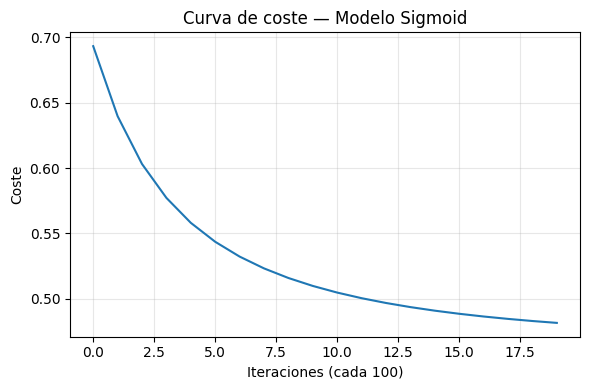

In [39]:
results_sigmoid = {
    'costs': list(d_sigmoid['costs']),
    'acc_train': d_sigmoid['acc_train'],
    'acc_test': d_sigmoid['acc_test']
}

plt.figure(figsize=(6, 4))
plt.plot(np.squeeze(results_sigmoid['costs']), color='#1f77b4')
plt.ylabel('Coste')
plt.xlabel('Iteraciones (cada 100)')
plt.title('Curva de coste — Modelo Sigmoid')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Varios learning rates (sigmoid)** — Se entrena el modelo con distintas tasas de aprendizaje para ver cómo afectan la convergencia y el coste.

Learning rate: 0.1
train accuracy: 77.04 %
test accuracy: 75.32 %
---
Learning rate: 0.05
train accuracy: 77.04 %
test accuracy: 75.32 %
---
Learning rate: 0.01
train accuracy: 76.55 %
test accuracy: 75.32 %
---
Learning rate: 0.005
train accuracy: 76.87 %
test accuracy: 72.73 %
---
Learning rate: 0.001
train accuracy: 76.06 %
test accuracy: 70.78 %
---


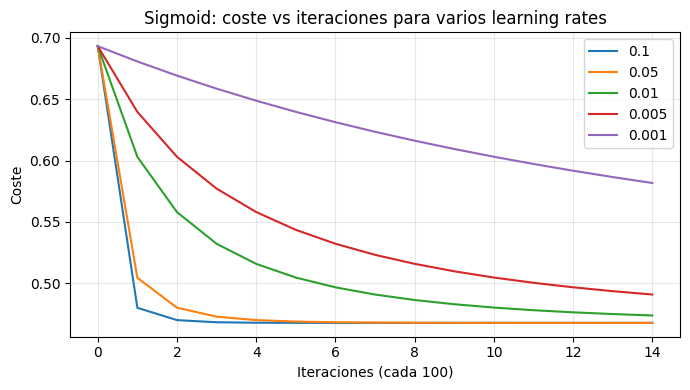

In [40]:
learning_rates_sigmoid = [0.1, 0.05, 0.01, 0.005, 0.001]
models_sigmoid_lr = {}

for lr in learning_rates_sigmoid:
    print("Learning rate:", lr)
    models_sigmoid_lr[str(lr)] = model_sigmoid(
        train_set_x, train_set_y, test_set_x, test_set_y,
        num_iterations=1500, learning_rate=lr, print_cost=False
    )
    print("---")

plt.figure(figsize=(7, 4))
for lr in learning_rates_sigmoid:
    plt.plot(np.squeeze(models_sigmoid_lr[str(lr)]["costs"]), label=str(lr))
plt.ylabel('Coste')
plt.xlabel('Iteraciones (cada 100)')
plt.title('Sigmoid: coste vs iteraciones para varios learning rates')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Análisis — Sigmoid**  
Se observa la curva de coste y los accuracies de entrenamiento y test. Con sigmoid + cross-entropy el modelo converge; el accuracy en test da una idea de la capacidad de generalización en este dataset. Con varios learning rates se ve si uno muy alto oscila o uno muy bajo converge lento.

---

## 3. Modelo con Tanh

Mismo flujo que antes pero con **activación tanh** y **coste MSE**. Las etiquetas se mapean a \(\{-1, +1\}\) para el MSE. Todo es independiente de la sección Sigmoid.

**Activación tanh** — Salida en \((-1, 1)\). Se usa con MSE.

In [41]:
def tanh_activation(z):
    """
    Función de activación tanh. Salida en (-1, 1).
    Se usa junto con el coste MSE (y etiquetas en {-1, 1}).
    """
    return np.tanh(z)

**Propagación (forward y backward)** — Coste MSE y gradientes para tanh. Etiquetas en \(\{-1, 1\}\).

In [42]:
def propagate_tanh(w, b, X, Y):
    """
    Forward y backward con tanh + MSE.
    Las etiquetas Y se mapean a {-1, 1} para el MSE.
    """
    m = X.shape[1]
    Y_tanh = 2.0 * Y - 1.0  # {0,1} -> {-1, 1}

    Z = np.dot(w.T, X) + b
    A = np.tanh(Z)
    cost = (1.0 / (2 * m)) * np.sum((A - Y_tanh) ** 2)

    dZ = (1.0 / m) * (A - Y_tanh) * (1 - A ** 2)
    dw = (1.0 / m) * np.dot(X, dZ.T)
    db = (1.0 / m) * np.sum(dZ)

    cost = np.squeeze(cost)
    return {"dw": dw, "db": db}, cost

**Optimización** — Descenso de gradiente usando la propagación tanh.

In [43]:
def optimize_tanh(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    Descenso de gradiente usando propagate_tanh.
    Devuelve parámetros finales, últimos gradientes y lista de costes.
    """
    costs = []

    for i in range(num_iterations):
        grads, cost = propagate_tanh(w, b, X, Y)
        dw, db = grads["dw"], grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    return {"w": w, "b": b}, grads, costs

**Predicción** — Umbral 0 sobre la salida tanh (clase 1 si \(a > 0\)).

In [44]:
def predict_tanh(w, b, X):
    """
    Predicción con tanh: clase 1 si A > 0, si no 0.
    """
    w = w.reshape(X.shape[0], 1)
    A = np.tanh(np.dot(w.T, X) + b)
    Y_prediction = (A > 0).astype(np.float64)
    return Y_prediction

**Modelo completo (tanh)**

In [45]:
def model_tanh(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Entrena el modelo completo con tanh: inicializa, optimiza y predice.
    Devuelve un diccionario con costs, predicciones, w, b, acc_train, acc_test, etc.
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize_tanh(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w, b = params["w"], params["b"]

    Y_prediction_test = predict_tanh(w, b, X_test)
    Y_prediction_train = predict_tanh(w, b, X_train)

    acc_train = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    acc_test = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100

    print("train accuracy: %.2f %%" % acc_train)
    print("test accuracy: %.2f %%" % acc_test)

    return {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w, "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations,
        "acc_train": acc_train,
        "acc_test": acc_test
    }

**Entrenar modelo tanh**

In [46]:
d_tanh = model_tanh(train_set_x, train_set_y, test_set_x, test_set_y,
                    num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.500000
Cost after iteration 100: 0.499578
Cost after iteration 200: 0.499157
Cost after iteration 300: 0.498737
Cost after iteration 400: 0.498318
Cost after iteration 500: 0.497900
Cost after iteration 600: 0.497483
Cost after iteration 700: 0.497068
Cost after iteration 800: 0.496653
Cost after iteration 900: 0.496240
Cost after iteration 1000: 0.495828
Cost after iteration 1100: 0.495417
Cost after iteration 1200: 0.495007
Cost after iteration 1300: 0.494598
Cost after iteration 1400: 0.494190
Cost after iteration 1500: 0.493784
Cost after iteration 1600: 0.493378
Cost after iteration 1700: 0.492974
Cost after iteration 1800: 0.492570
Cost after iteration 1900: 0.492168
train accuracy: 75.08 %
test accuracy: 70.13 %


**Resultados y gráfica de coste (tanh)**

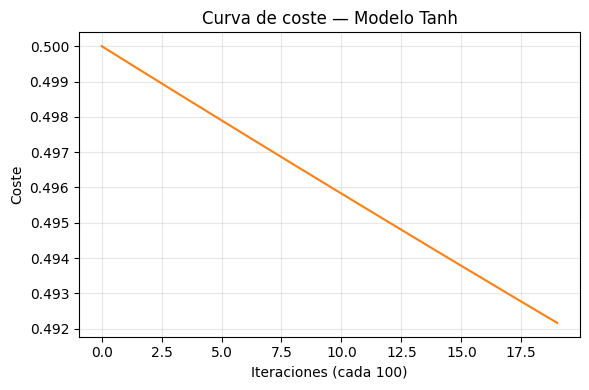

In [47]:
results_tanh = {
    'costs': list(d_tanh['costs']),
    'acc_train': d_tanh['acc_train'],
    'acc_test': d_tanh['acc_test']
}

plt.figure(figsize=(6, 4))
plt.plot(np.squeeze(results_tanh['costs']), color='#ff7f0e')
plt.ylabel('Coste')
plt.xlabel('Iteraciones (cada 100)')
plt.title('Curva de coste — Modelo Tanh')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Varios learning rates (tanh)** — Mismo análisis de sensibilidad al learning rate para el modelo tanh.

Learning rate: 0.1
train accuracy: 75.73 %
test accuracy: 70.78 %
---
Learning rate: 0.05
train accuracy: 75.41 %
test accuracy: 70.13 %
---
Learning rate: 0.01
train accuracy: 75.08 %
test accuracy: 70.13 %
---
Learning rate: 0.005
train accuracy: 75.08 %
test accuracy: 70.13 %
---
Learning rate: 0.001
train accuracy: 75.08 %
test accuracy: 70.13 %
---


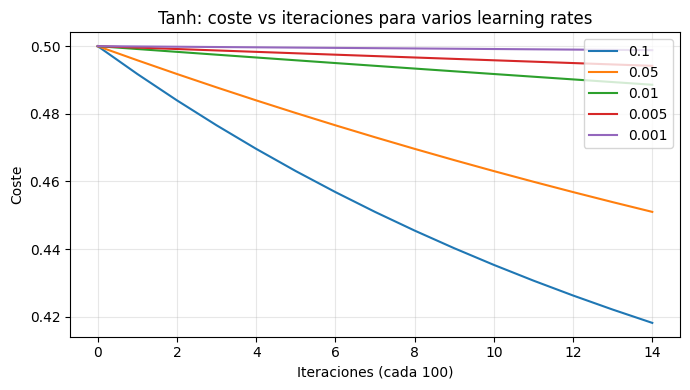

In [48]:
learning_rates_tanh = [0.1, 0.05, 0.01, 0.005, 0.001]
models_tanh_lr = {}

for lr in learning_rates_tanh:
    print("Learning rate:", lr)
    models_tanh_lr[str(lr)] = model_tanh(
        train_set_x, train_set_y, test_set_x, test_set_y,
        num_iterations=1500, learning_rate=lr, print_cost=False
    )
    print("---")

plt.figure(figsize=(7, 4))
for lr in learning_rates_tanh:
    plt.plot(np.squeeze(models_tanh_lr[str(lr)]["costs"]), label=str(lr))
plt.ylabel('Coste')
plt.xlabel('Iteraciones (cada 100)')
plt.title('Tanh: coste vs iteraciones para varios learning rates')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Análisis — Tanh**  
Con tanh + MSE la curva de coste y los accuracies permiten comparar directamente con el modelo sigmoid en la siguiente sección. La sensibilidad al learning rate puede ser distinta a la de sigmoid.

---

## 4. Comparación Sigmoid vs Tanh

Gráficas comparativas de coste y accuracy (train/test) para ambos modelos.

**Coste y accuracy (modelo principal)**

**Comparación por learning rate** — Curvas de coste para varios LRs. Ejecutar antes las celdas "Varios learning rates" en Sigmoid y Tanh.

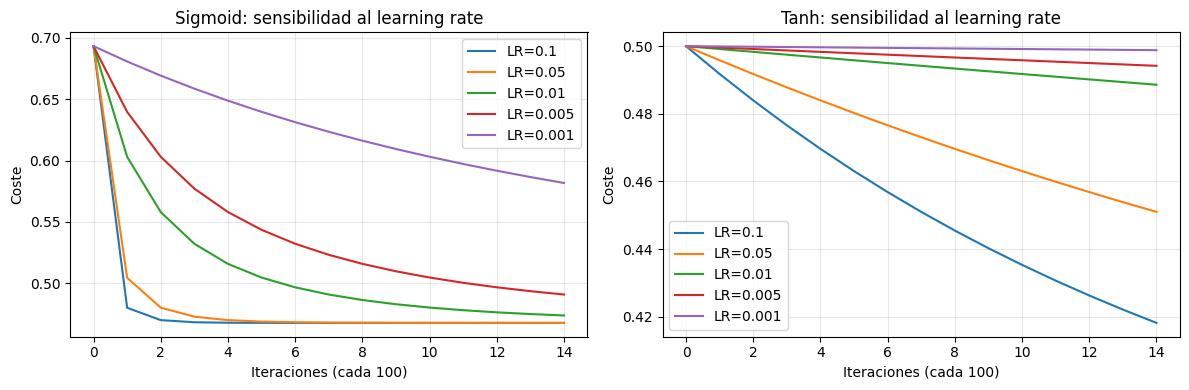

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for lr in learning_rates_sigmoid:
    ax1.plot(np.squeeze(models_sigmoid_lr[str(lr)]["costs"]), label='LR=' + str(lr))
ax1.set_ylabel('Coste')
ax1.set_xlabel('Iteraciones (cada 100)')
ax1.set_title('Sigmoid: sensibilidad al learning rate')
ax1.legend()
ax1.grid(True, alpha=0.3)
for lr in learning_rates_tanh:
    ax2.plot(np.squeeze(models_tanh_lr[str(lr)]["costs"]), label='LR=' + str(lr))
ax2.set_ylabel('Coste')
ax2.set_xlabel('Iteraciones (cada 100)')
ax2.set_title('Tanh: sensibilidad al learning rate')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Tabla resumen** — Coste final, accuracy train/test y brecha (train − test; mayor brecha puede indicar overfitting).

In [50]:
import pandas as pd
from IPython.display import display

cost_final_sig = results_sigmoid['costs'][-1]
cost_final_tanh = results_tanh['costs'][-1]
gap_sig = results_sigmoid['acc_train'] - results_sigmoid['acc_test']
gap_tanh = results_tanh['acc_train'] - results_tanh['acc_test']

# Tabla: modelo principal
df_principal = pd.DataFrame({
    'Modelo': ['Sigmoid', 'Tanh'],
    'Coste final': [cost_final_sig, cost_final_tanh],
    'Acc train %': [results_sigmoid['acc_train'], results_tanh['acc_train']],
    'Acc test %': [results_sigmoid['acc_test'], results_tanh['acc_test']],
    'Gap': [gap_sig, gap_tanh]
})
df_principal = df_principal.round({'Coste final': 4, 'Acc train %': 2, 'Acc test %': 2, 'Gap': 2})
print('Modelo principal')
display(df_principal.style.set_caption('Comparación Sigmoid vs Tanh').set_table_styles([
    {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '14px')]},
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]))

# Tabla: por learning rate (Sigmoid), ordenado por Acc test (mayor → menor)
filas_sig = [(lr, models_sigmoid_lr[str(lr)]['costs'][-1],
              models_sigmoid_lr[str(lr)]['acc_train'], models_sigmoid_lr[str(lr)]['acc_test'])
             for lr in learning_rates_sigmoid]
filas_sig.sort(key=lambda x: x[3], reverse=True)
df_sig = pd.DataFrame(filas_sig, columns=['LR', 'Coste final', 'Acc train %', 'Acc test %'])
df_sig = df_sig.round({'Coste final': 4, 'Acc train %': 2, 'Acc test %': 2})
print('Por learning rate (Sigmoid) — ordenado por Acc test (mayor → menor)')
display(df_sig.style.set_caption('Sigmoid por LR').set_table_styles([
    {'selector': 'caption', 'props': [('font-weight', 'bold')]},
    {'selector': 'th, td', 'props': [('text-align', 'center')]}
]))

# Tabla: por learning rate (Tanh), ordenado por Acc test (mayor → menor)
filas_tanh = [(lr, models_tanh_lr[str(lr)]['costs'][-1],
               models_tanh_lr[str(lr)]['acc_train'], models_tanh_lr[str(lr)]['acc_test'])
              for lr in learning_rates_tanh]
filas_tanh.sort(key=lambda x: x[3], reverse=True)
df_tanh = pd.DataFrame(filas_tanh, columns=['LR', 'Coste final', 'Acc train %', 'Acc test %'])
df_tanh = df_tanh.round({'Coste final': 4, 'Acc train %': 2, 'Acc test %': 2})
print('Por learning rate (Tanh) — ordenado por Acc test (mayor → menor)')
display(df_tanh.style.set_caption('Tanh por LR').set_table_styles([
    {'selector': 'caption', 'props': [('font-weight', 'bold')]},
    {'selector': 'th, td', 'props': [('text-align', 'center')]}
]))

Modelo principal


,Modelo,Coste final,Acc train %,Acc test %,Gap
0,Sigmoid,0.481600,77.040000,73.380000,3.660000
1,Tanh,0.492200,75.080000,70.130000,4.950000


Por learning rate (Sigmoid) — ordenado por Acc test (mayor → menor)


,LR,Coste final,Acc train %,Acc test %
0,0.100000,0.467800,77.040000,75.320000
1,0.050000,0.467800,77.040000,75.320000
2,0.010000,0.473900,76.550000,75.320000
3,0.005000,0.490900,76.870000,72.730000
4,0.001000,0.581700,76.060000,70.780000


Por learning rate (Tanh) — ordenado por Acc test (mayor → menor)


,LR,Coste final,Acc train %,Acc test %
0,0.100000,0.418200,75.730000,70.780000
1,0.050000,0.451000,75.410000,70.130000
2,0.010000,0.488600,75.080000,70.130000
3,0.005000,0.494200,75.080000,70.130000
4,0.001000,0.498800,75.080000,70.130000


**Coste y accuraccy**

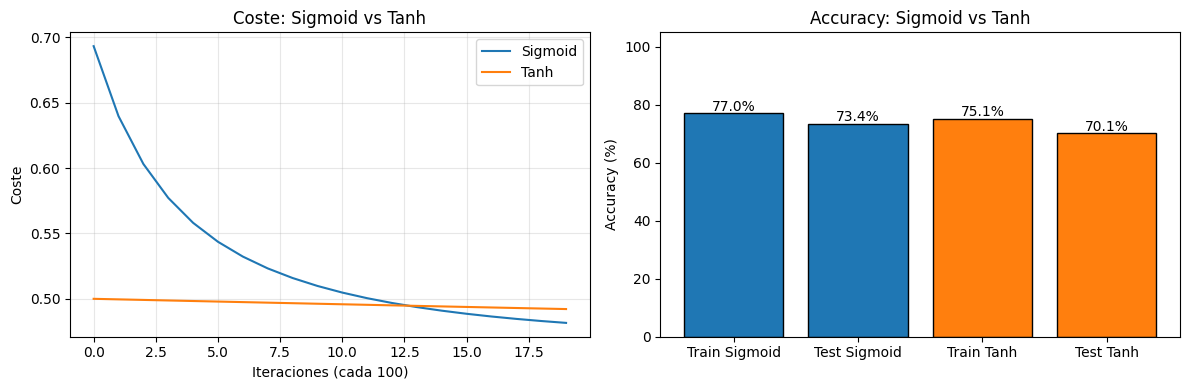

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(np.squeeze(results_sigmoid['costs']), label='Sigmoid', color='#1f77b4')
ax1.plot(np.squeeze(results_tanh['costs']), label='Tanh', color='#ff7f0e')
ax1.set_ylabel('Coste')
ax1.set_xlabel('Iteraciones (cada 100)')
ax1.set_title('Coste: Sigmoid vs Tanh')
ax1.legend()
ax1.grid(True, alpha=0.3)

labels = ['Train Sigmoid', 'Test Sigmoid', 'Train Tanh', 'Test Tanh']
values = [results_sigmoid['acc_train'], results_sigmoid['acc_test'], results_tanh['acc_train'], results_tanh['acc_test']]
colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e']
bars = ax2.bar(labels, values, color=colors, edgecolor='black')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy: Sigmoid vs Tanh')
ax2.set_ylim(0, 105)
for b in bars:
    ax2.text(b.get_x() + b.get_width()/2, b.get_height() + 1, str(round(b.get_height(), 1)) + '%', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

**Análisis comparativo**  
Se comparan coste, convergencia, accuracy y sensibilidad al learning rate. La tabla (en la celda siguiente) resume coste final, acc train/test y brecha (overfitting). Así se ve qué activación y qué LR dan mejor equilibrio.